In [1]:
import numpy as np 
import os
import glob
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
#import cv2
#from libtiff import TIFF
from scipy.misc import imresize
from collections import Counter
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
#os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from keras.models import *
from keras.layers import Input, merge, Conv2D, MaxPooling2D, UpSampling2D, Dropout, Cropping2D, Dense, Flatten
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
from keras.models import load_model
from keras.utils import np_utils
from sklearn.model_selection import train_test_split, StratifiedKFold
from keras.callbacks import ModelCheckpoint,CSVLogger

In [3]:
class dataProcess(object):

	def __init__(self, out_rows, out_cols, melanoma_path = "./melanoma", others_path = "./others", label_path = "./gt", npy_path = ".", img_type = "jpg"):


		self.out_rows = out_rows
		self.out_cols = out_cols
		self.melanoma_path = melanoma_path
		self.others_path = others_path
		self.img_type = img_type
		#self.test_path = test_path
		self.npy_path = npy_path
		self.label_path = label_path

	def create_train_data(self):
		i = 0
		print('-'*30)
		print('Creating training images...')
		print('-'*30)
		imgs1 = glob.glob(self.melanoma_path+"/*."+self.img_type)
		imgs2 = glob.glob(self.others_path+"/*."+self.img_type)
		n = len(imgs1)+len(imgs2)
		print(n)
		imgdatas = np.ndarray((n,self.out_rows,self.out_cols,3), dtype=np.float32)
		imglabels = np.ndarray((n,self.out_rows,self.out_cols,1), dtype=np.float32)
		i=0
        
		for imgname in imgs1:
			midname = imgname[imgname.rindex("/")+1:]
			new_name = midname.replace('.jpg','')
			img = load_img(self.melanoma_path + "/" + midname,grayscale = False)
			img = imresize(img,(256, 256,3))
			img = img_to_array(img)
			label = load_img(self.label_path + "/" + new_name+'_segmentation.png',grayscale =True)
			label = imresize(label,(256, 256,1)) 
			label=img_to_array(label) 
			imgdatas[i] = img
			imglabels[i] = label
			print i
			i += 1
            
		for imgname in imgs2:
			midname = imgname[imgname.rindex("/")+1:]
			new_name = midname.replace('.jpg','')
			img = load_img(self.others_path + "/" + midname,grayscale = False)
			img=imresize(img,(256,256,3))
			img = img_to_array(img)
			label = load_img(self.label_path + "/" +new_name+'_segmentation.png' ,grayscale = True)
			label=imresize(label,(256,256,1))
			label=img_to_array(label) 
			imgdatas[i] = img
			imglabels[i] = label
			print i
			i += 1


		train_samples, validation_samples,train_samples_mask,validation_samples_mask = train_test_split(imgdatas,imglabels, test_size=0.2,shuffle=False)
               
		print('loading done')
   
		np.save(self.npy_path + '/imgs_train_segment.npy', train_samples)
		np.save(self.npy_path + '/imgs_mask_train_segment.npy', train_samples_mask)
		np.save(self.npy_path + '/imgs_test_segment.npy', validation_samples)
		np.save(self.npy_path + '/imgs_mask_test_segment.npy', validation_samples_mask)
		print('Saving to .npy files done.')

	def load_train_data(self):
		print('-'*30)
		print('load train images...')
		print('-'*30)
		imgs_train = np.load(self.npy_path+"/imgs_train_segment.npy")
		imgs_mask_train = np.load(self.npy_path+"/imgs_mask_train_segment.npy")
		imgs_train = imgs_train.astype('float32')
		imgs_mask_train = imgs_mask_train.astype('float32')
		imgs_train /= 255
		imgs_mask_train /= 255
		imgs_mask_train[imgs_mask_train > 0.5] = 1
		imgs_mask_train[imgs_mask_train <= 0.5] = 0
		return imgs_train,imgs_mask_train

	def load_test_data(self):
        
		print('-'*30)
		print('load test images...')
		print('-'*30)
		imgs_test = np.load(self.npy_path+"/imgs_test_segment.npy")
		imgs_test = imgs_test.astype('float32')
		imgs_test /= 255
		imgs_mask_test = np.load(self.npy_path+"/imgs_mask_test_segment.npy")
		imgs_mask_test = imgs_mask_test.astype('float32')
		imgs_mask_test /= 255
		imgs_mask_test[imgs_mask_test > 0.5] = 1
		imgs_mask_test[imgs_mask_test <= 0.5] = 0
		return imgs_test, imgs_mask_test


In [3]:
mydata = dataProcess(256,256)
mydata.create_train_data()

------------------------------
Creating training images...
------------------------------
2000
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253

TypeError: Invalid parameters passed: {'shuffle': False}

In [4]:
def dice_coef(y_true, y_pred, smooth=1):

    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

In [21]:
import matplotlib.pyplot as plt
class myUnet(dataProcess):

	def __init__(self, img_rows = 256, img_cols = 256):

		self.img_rows = img_rows
		self.img_cols = img_cols

	def load_data(self):

		mydata = dataProcess(self.img_rows, self.img_cols)
		imgs_train, imgs_mask_train = mydata.load_train_data()
		imgs_test, imgs_mask_test = mydata.load_test_data()
		return  imgs_train,imgs_mask_train,imgs_test, imgs_mask_test

	def get_unet(self):

		inputs = Input(shape=(self.img_rows, self.img_cols,3))

		conv1 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',input_shape=(256, 256, 3))(inputs)
		print ("conv1 shape:",conv1.shape)
		conv1 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
		print "conv1 shape:",conv1.shape
		pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
		print "pool1 shape:",pool1.shape

		conv2 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
		print "conv2 shape:",conv2.shape
		conv2 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
		print "conv2 shape:",conv2.shape
		pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
		print "pool2 shape:",pool2.shape

		conv3 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
		print "conv3 shape:",conv3.shape
		conv3 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
		print "conv3 shape:",conv3.shape
		pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
		print "pool3 shape:",pool3.shape

		conv4 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
		conv4 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
		drop4 = Dropout(0.5)(conv4)
		pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

		conv5 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
		conv5 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
		drop5 = Dropout(0.5)(conv5)

		up6 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
		merge6 = merge([drop4,up6], mode = 'concat', concat_axis = 3)
		conv6 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
		conv6 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

		up7 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
		merge7 = merge([conv3,up7], mode = 'concat', concat_axis = 3)
		conv7 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
		conv7 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

		up8 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
		merge8 = merge([conv2,up8], mode = 'concat', concat_axis = 3)
		conv8 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
		conv8 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

		up9 = Conv2D(16, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
		merge9 = merge([conv1,up9], mode = 'concat', concat_axis = 3)
		conv9 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
		conv9 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
		conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
		conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

		model = Model(input = inputs, output = conv10)

		model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = [dice_coef])

		return model



	def train(self):

		print("loading data")
		imgs_train,imgs_mask_train,imgs_test,imgs_mask_test= self.load_data()
                

		print("loading data done")

    
		name_weights = "segmentation_weights.hdf5"             
		#csvlog = "segmentation_log.csv"
		#csv_logger = CSVLogger(csvlog)
		model_checkpoint = ModelCheckpoint(name_weights, monitor='loss',verbose=1, save_best_only=True)
		model = load_model(name_weights, custom_objects={'dice_coef': dice_coef}) 
		#model = self.get_unet()
		print model.summary()

		#model.fit(imgs_train, imgs_mask_train, batch_size=4, nb_epoch=40, verbose=1,validation_data=(imgs_test, imgs_mask_test), shuffle=False, callbacks=[model_checkpoint,csv_logger])
		imgs_mask_test_res = model.predict(imgs_test[0].reshape(1,256,256,3), batch_size=1, verbose=1)
		np.save('imgs_mask_test_res.npy', imgs_mask_test_res)   
        
	def save_img(self):

		print("array to image")
		imgs = np.load('imgs_mask_test_res.npy')
		imgs_gt = np.load('imgs_test_segment.npy')
		imgs_gt_mask = np.load('imgs_mask_test_segment.npy')       
		print imgs.shape 
        
		for i in range(1):            # display predicted mask for 1 test images
			img = imgs[i]
			img = array_to_img(img)
			img_gt = imgs_gt[i]
			img_gt = array_to_img(img_gt)
			img_gt_mask = imgs_gt_mask[i]
			img_gt_mask = array_to_img(img_gt_mask)
			plt.subplot(221)
			plt.imshow(img)#, cmap=plt.get_cmap('gray'))
			plt.subplot(222)
			plt.imshow(img_gt)#, cmap=plt.get_cmap('gray'))
			plt.subplot(223)
			plt.imshow(img_gt_mask)#, cmap=plt.get_cmap('gray'))

			plt.show()
			img.save("%d.png"%(i))
			print "img"


loading data
------------------------------
load test images...
------------------------------
loading data done
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 256, 256, 3)   0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 256, 256, 8)   224         input_1[0][0]                    
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                (None, 256, 256, 8)   584         conv2d_1[0][0]                   
____________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)   (None, 128, 128, 8)   0           conv2d_2[0][

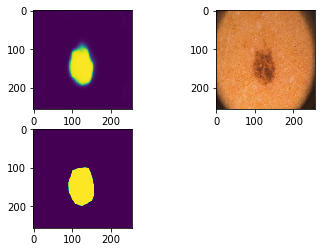

img


In [22]:
mydata= dataProcess(256,256,3)
myunet = myUnet(dataProcess)
myunet.train()
myunet.save_img()